# Analyze SSIM similarity between MPI and Era

GPT3 "write as email" summary of title:
Hello,
I am wondering if you could help me analyze the SSIM similarity between MPI and Era? I am not sure what the best way to go about this is, and any help would be greatly appreciated. Thank you!

### TOC
 [1. Load data](#ld)<br>
 [2. SSIM](#ssim)<br>
 





In [1]:
from IPython import display

import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


In [3]:
# define internal pic res
ires = 128
res = 128
nvars = 16
mnvars = 16


In [4]:
 mnvars

16

<a id='ld'></a>
# Load data

In [48]:
###################################
## LOAD MPI UATM + Surface: hist ##
###################################
def load_mpi_hist(ii, ii2):
    global mnvars
    
    mnvars = 16
        
    ########### LOAd MPI ############
    mstart = 0

    mndays = 20454       # 1950-2005

    #ncks -O -d lat,23.375,55.125 -d lon,-112.375,-80.625 $f $of
    #ncatted -a missing_value,$v,o,f,0.0 -a _FillValue,$v,o,f,0.0 $of
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    tslice = slice('1950-01-01T00:00:00', '2006-01-01T00:00:00')
    #tslice = slice('1979-01-01T00:00:00', '2006-01-01T00:00:00')
    tslice2 = slice('1979-01-01T00:00:00', '1979-01-02T00:00:00')
    
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]

    mdv9 = xr.open_dataset(d+'pr_MPI-ESM-LR_historical_r1i1p1_NAmerica_19500101-20051231_dayavg_mpigrid.nc')['pr'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2] *(60*60*24)
    mdv10 = xr.open_dataset(d+'tasmax_MPI-ESM-LR_historical_r1i1p1_NAmerica_19500101-20051231_dayavg_mpigrid.nc')['tasmax'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2] -273.15
    mdv11 = xr.open_dataset(d+'tasmin_MPI-ESM-LR_historical_r1i1p1_NAmerica_19500101-20051231_dayavg_mpigrid.nc')['tasmin'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2] -273.15
    mdv12 = xr.open_dataset(d+'uas_MPI-ESM-LR_historical_r1i1p1_NAmerica_19500101-20051231_dayavg_mpigrid.nc')['uas'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv13 = xr.open_dataset(d+'vas_MPI-ESM-LR_historical_r1i1p1_NAmerica_19500101-20051231_dayavg_mpigrid.nc')['vas'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv14 = xr.open_dataset(d+'shums_MPI-ESM-LR_historical_r1i1p1_NAmerica_19500101-20051231_dayavg_mpigrid.nc')['shums'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv15 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'].sel(time=tslice2))[ii:ii2]
    mdv15[np.isnan(mdv15)] = 1.  # nan has to be 1 or else it's all 0's

    
#     # normalize each var to 0-1
#     [[mv1min,mv1max],[mv2min,mv2max],[mv3min,mv3max],[mv4min,mv4max],[mv5min,mv5max],[mv6min,mv6max],[mv7min,mv7max],[mv8min,mv8max],[mv9min,mv9max],[mv10min,mv10max],[mv11min,mv11max],[mv12min,mv12max],[mv13min,mv13max],[mv14min,mv14max],[mv15min,mv15max],[mv16min,mv16max]] = minmaxi_mpi # saved w/ model
#     mdv1 = (mdv1-mv1min)/(mv1max-mv1min)
#     mdv2 = (mdv2-mv2min)/(mv2max-mv2min)
#     mdv3 = (mdv3-mv3min)/(mv3max-mv3min)
#     mdv4 = (mdv4-mv4min)/(mv4max-mv4min)
#     mdv5 = (mdv5-mv5min)/(mv5max-mv5min)
#     mdv6 = (mdv6-mv6min)/(mv6max-mv6min)
#     mdv7 = (mdv7-mv7min)/(mv7max-mv7min)
#     mdv8 = (mdv8-mv8min)/(mv8max-mv8min)
#     mdv9 = (mdv9-mv9min)/(mv9max-mv9min)
#     mdv10 = (mdv10-mv10min)/(mv10max-mv10min)
#     mdv11 = (mdv11-mv11min)/(mv11max-mv11min)
#     mdv12 = (mdv12-mv12min)/(mv12max-mv12min)
#     mdv13 = (mdv13-mv13min)/(mv13max-mv13min)
#     mdv14 = (mdv14-mv14min)/(mv14max-mv14min)
#     mdv15 = (mdv15-mv15min)/(mv15max-mv15min)

    mndays = len(mdv9)      # 1979-2010
    #print(len(mdv9) , len(mdv1) )
    
    dd=[]
    for ii in range(mndays):
        # input samples
        rowdd = []
        for iii in [0]: #range(4):
        #for iii in range(4):
            rowdd.append( cv2.resize(np.array(mdv1[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv2[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv3[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv4[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv5[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv6[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv7[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv8[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv9[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv10[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv11[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv12[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv13[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv14[ii*1+iii]),(ires,ires)) )
            rowdd.append( np.array(mdv15[0]) )

        
            # add doy
            rowdd.append( np.ones((ires,ires),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)

            dd.append(rowdd)


    # add channel for cos
    mnvars = 16

    d = np.array(dd)
    
    mndays = len(mdv1)   

    # input samples
    samples = []
    #print("mndays", mndays)
    for t in range(mndays):
        samples.append(d[t])
    samples = torch.tensor(np.reshape(samples, (mndays, mnvars, ires, ires)), dtype=torch.float32)

    return samples

    
    
    
    
    


In [49]:
samples_mpi = load_mpi_hist(0,1)
samples_mpi.shape

torch.Size([1, 16, 128, 128])

In [50]:
def load_era(ii, ii2):
    global mnvars
    
    mnvars = 16
    
    ########### LOAD ERA############

    # load eraionmpi
    mnstart = 0
    tslice = slice('1979-01-01T00:00:00', '2017-01-01T00:00:00')
    #tslice = slice('1979-01-01T00:00:00', '2006-01-01T00:00:00')

    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'].sel(time=tslice, lat=slice(23.375,55), lon=slice(-112.375,-81))[ii:ii2]

    mdv9 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'].sel(time=tslice))[ii:ii2]
    mdv9[np.isnan(mdv9)] = 2.7173626
    mdv10 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'].sel(time=tslice))[ii:ii2]
    mdv10[np.isnan(mdv10)] = -5.6562285
    mdv11 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'].sel(time=tslice))[ii:ii2]
    mdv11[np.isnan(mdv11)] = -17.37329
    mdv12 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'].sel(time=tslice))[ii:ii2]
    mdv12[np.isnan(mdv12)] = 3.4043167
    mdv13 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'].sel(time=tslice))[ii:ii2]
    mdv13[np.isnan(mdv13)] = -1.9973005
    mdv14 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'].sel(time=tslice))[ii:ii2]
    mdv14[np.isnan(mdv14)] = 0.00156806
    mdv15 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'].sel(time=tslice))[ii:ii2]
    mdv15[np.isnan(mdv15)] = 1. # nan has to be 1 or else it's all 0's

#     # Find min/max for each variable
#     mv1max = minmaxi_era[0][1]; mv1min = minmaxi_era[0][0]
#     mv2max = minmaxi_era[1][1]; mv2min = minmaxi_era[1][0]
#     mv3max = minmaxi_era[2][1]; mv3min = minmaxi_era[2][0]
#     mv4max = minmaxi_era[3][1]; mv4min = minmaxi_era[3][0]
#     mv5max = minmaxi_era[4][1]; mv5min = minmaxi_era[4][0]
#     mv6max = minmaxi_era[5][1]; mv6min = minmaxi_era[5][0]
#     mv7max = minmaxi_era[6][1]; mv7min = minmaxi_era[6][0]
#     mv8max = minmaxi_era[7][1]; mv8min = minmaxi_era[7][0]
#     mv9max = minmaxi_era[8][1]; mv9min = minmaxi_era[8][0]
#     mv10max = minmaxi_era[9][1]; mv10min = minmaxi_era[9][0]
#     mv11max = minmaxi_era[10][1]; mv11min = minmaxi_era[10][0]
#     mv12max = minmaxi_era[11][1]; mv12min = minmaxi_era[11][0]
#     mv13max = minmaxi_era[12][1]; mv13min = minmaxi_era[12][0]
#     mv14max = minmaxi_era[13][1]; mv14min = minmaxi_era[13][0]
#     mv15max = 1; mv15min = 0
#     mv16max = 1; mv16min = 0

    #[[mv1min,mv1max],[mv2min,mv2max],[mv3min,mv3max],[mv4min,mv4max],[mv5min,mv5max],[mv6min,mv6max],[mv7min,mv7max],[mv8min,mv8max],[mv9min,mv9max],[mv10min,mv10max],[mv11min,mv11max],[mv12min,mv12max],[mv13min,mv13max],[mv14min,mv14max],[mv15min,mv15max]] = minmaxi_era # saved w/ model

#     # normalize each var to 0-1
#     mdv1 = (mdv1-mv1min)/(mv1max-mv1min)
#     mdv2 = (mdv2-mv2min)/(mv2max-mv2min)
#     mdv3 = (mdv3-mv3min)/(mv3max-mv3min)
#     mdv4 = (mdv4-mv4min)/(mv4max-mv4min)
#     mdv5 = (mdv5-mv5min)/(mv5max-mv5min)
#     mdv6 = (mdv6-mv6min)/(mv6max-mv6min)
#     mdv7 = (mdv7-mv7min)/(mv7max-mv7min)
#     mdv8 = (mdv8-mv8min)/(mv8max-mv8min)
#     mdv9 = (mdv9-mv9min)/(mv9max-mv9min)
#     mdv10 = (mdv10-mv10min)/(mv10max-mv10min)
#     mdv11 = (mdv11-mv11min)/(mv11max-mv11min)
#     mdv12 = (mdv12-mv12min)/(mv12max-mv12min)
#     mdv13 = (mdv13-mv13min)/(mv13max-mv13min)
#     mdv14 = (mdv14-mv14min)/(mv14max-mv14min)


    mndays = len(mdv9)      # 1979-2010
    #print(len(mdv9) , len(mdv1) )

    # synthetically create 16x16 input samples via bilinear scaling
    dd=[]
    for ii in range(mndays):
        # input samples
        rowdd = []
        for iii in [0]: #range(4):
        #for iii in range(4):
            #print(mdv1[ii*1+iii], len(mdv1))
            rowdd.append( cv2.resize(np.array(mdv1[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv2[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv3[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv4[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv5[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv6[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv7[ii*1+iii]),(ires,ires)) )
            rowdd.append( cv2.resize(np.array(mdv8[ii*1+iii]),(ires,ires)) )
            rowdd.append( np.array(mdv9[ii*1+iii]) )
            rowdd.append( np.array(mdv10[ii*1+iii]) )
            rowdd.append( np.array(mdv11[ii*1+iii]) )
            rowdd.append( np.array(mdv12[ii*1+iii]) )
            rowdd.append( np.array(mdv13[ii*1+iii]) )
            rowdd.append( np.array(mdv14[ii*1+iii]) )
            rowdd.append( np.array(mdv15[ii*1+iii]) )
            
            # add doy
            rowdd.append( np.ones((ires,ires),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)

        dd.append(rowdd)


    # add channel for cos
    mnvars = 16

    d = np.array(dd)

    # input samples
    samples = []
    #print("mndays", mndays)
    for t in range(mndays):
        samples.append(d[t])
    samples = torch.tensor(np.reshape(samples, (mndays, mnvars, ires, ires)), dtype=torch.float32)

    return samples


In [51]:
samples_era = load_era(0,1)
samples_era.shape

torch.Size([1, 16, 128, 128])

# Plot routines

In [9]:
# Necessary for plot routines: lat/lon donor and mask donor
# lat/lon coordinate donor for plot routines
dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'].sel(time=slice('1979-01-01T00:00:00', '1979-01-02T00:00:00'))

# mask for plot routines
dv15 = np.array(xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'].sel(time=slice('1979-01-01T00:00:00', '1979-01-02T00:00:00')))
dv15[np.isnan(dv15)] = 1. # nan has to be 1 or else it's all 0's       

In [10]:
dv15.shape

(1, 128, 128)

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import xarray as xr

# metadata used for lat/lon backdrop
d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))


def plot_8v_abs(isample, modelname, vmin, vmax, cc=True):
#     varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
#     units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
#     cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
        
#     fig, axarr = plt.subplots(1, 8, figsize = (20,20))
#     for ii in range(8):
#         plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#         cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
#         cbar.set_label(units[ii])
#         axarr[ii].set_title(varmames[ii])
#     plt.suptitle(modelname, y=0.29, fontsize=16)
#     plt.show()
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    #cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'PuBuGn', 'coolwarm', 'Spectral', 'Spectral', 'PiYG', 'PuOr']

    # pass by value
    vmin = copy.deepcopy(vmin)
    vmax = copy.deepcopy(vmax)
    
    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))

    #vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
    #vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))
    
    # min of Q850 should be 0
    vmin[2] = 0

          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = dv1[0].lon
    lat = dv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        
#         # add wind barbs
#         x=[]; y=[]; u=[]; v=[]
#         for mm in range(0, 128, 20):
#             hx = []
#             for nn in range(0, 128, 20): 
#                 x.append(dv1[0][mm,nn].lon)
#                 y.append(dv1[0][mm,nn].lat)
#                 #u.append(isample[11][mm,nn]) # uas
#                 #v.append(isample[12][mm,nn]) # vas
#                 u.append(isample[0][mm,nn]) # u850
#                 v.append(isample[1][mm,nn]) # v850
#         axarr[ii].barbs(x, y, u, v, length=5, sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5), linewidth=0.95)

        # add huss850 contours
        if cc == True:
            x=[]; y=[];
            for mm in range(0, 128, 1):
                x.append(dv1[0][mm,mm].lon)
                y.append(dv1[0][mm,mm].lat)
            hx=[]; hy=[]
            for mm in range(0, 128, 1):
                hx = []
                for nn in range(0, 128, 1):
                    #hx.append(isample[2][mm,nn]) # q850
                    hx.append(isample[ii][mm,nn]) # q850
                hy.append(hx)
            X, Y = np.meshgrid(x, y)
            Z = np.array(hy)
            CS = axarr[ii].contour(X, Y, Z)
            axarr[ii].clabel(CS, inline=True, fontsize=10)


        
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()





In [12]:
def plot_8v_abs_surf(isample, modelname, vmin, vmax, cc=True):

    varmames = ['prec', 'tmax', 'tmin', 'uas', 'vas', 'huss', 'miss', 'yday']
    units = ['mm/day', 'C', 'C', 'm/s', 'm/s', 'kg/kg', '0..1', '0..1']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    #cmaps = ['BrBG', 'RdBu_r', 'RdBu_r', 'PiYG', 'PuOr', 'BrBG', 'Spectral', 'Spectral']
    #cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    cmaps = ['YlGnBu', 'coolwarm', 'coolwarm', 'PiYG', 'PuOr', 'PuBuGn', 'Spectral', 'Spectral']

    # pass by value
    vmin = copy.deepcopy(vmin)
    vmax = copy.deepcopy(vmax)
    
    # Ranges centered on zero for U, V
    vmin[3+8] = -max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmax[3+8] = max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmin[4+8] = -max(abs(vmin[4+8]), abs(vmax[4+8]))
    vmax[4+8] = max(abs(vmin[4+8]), abs(vmax[4+8]))
 
    # Ranges centered on zero for tmin, tmax
    vmin[1+8] = -max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmax[1+8] = max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmin[2+8] = -max(abs(vmin[2+8]), abs(vmax[2+8]))
    vmax[2+8] = max(abs(vmin[2+8]), abs(vmax[2+8]))
    
    # prec min should be 0
    vmin[8] = 0

    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = dv1[0].lon
    lat = dv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        
        # add huss850 contours
        if cc == True:
            x=[]; y=[];
            for mm in range(0, 128, 1):
                x.append(dv1[0][mm,mm].lon)
                y.append(dv1[0][mm,mm].lat)
            hx=[]; hy=[]
            for mm in range(0, 128, 1):
                hx = []
                for nn in range(0, 128, 1):
                    #hx.append(isample[2][mm,nn]) # q850
                    hx.append(isample[ii+8][mm,nn]) # q850
                hy.append(hx)
            X, Y = np.meshgrid(x, y)
            Z = np.array(hy)
            CS = axarr[ii].contour(X, Y, Z)
            axarr[ii].clabel(CS, inline=True, fontsize=10)


        # mask
        if ii != 6:
            image = isample[ii+8] * (1-dv15[0,:,:])
        else:
            image = isample[ii+8] 
        
        plot = axarr[ii].imshow(image[::-1,:], vmin=vmin[ii+8], vmax=vmax[ii+8], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()


<a id='ssim'></a>
## SSIM: match MPI to closest Era

In [13]:
ss = np.load('/glade/scratch/dkorytin/ssim_closest_mpi2era.npy')

In [14]:
ss2 = np.load('/glade/scratch/dkorytin/ssim_closest_mpi2era_bak.npy')

In [15]:
#np.save('/glade/scratch/dkorytin/ssim_closest_mpi2era_bak.npy', ss)

In [16]:
ss.shape

(20454, 5, 2)

In [18]:
sorted(ss[0,:,0].tolist()) 

[0.8555257320404053,
 0.8556615114212036,
 0.8571101427078247,
 0.8578702211380005,
 0.8590624332427979]

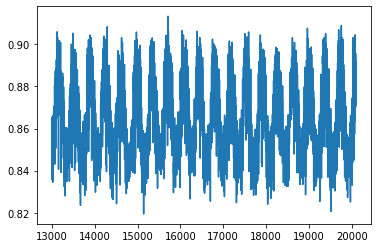

In [38]:
#plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(13000,20100), ss[13000:20100,4,0])

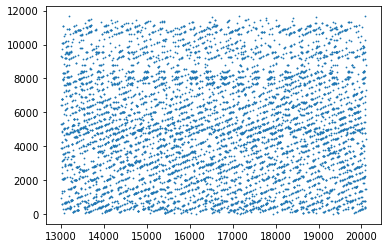

In [40]:
plt.scatter(range(13000,20100), ss[13000:20100,0,1], s=.6)

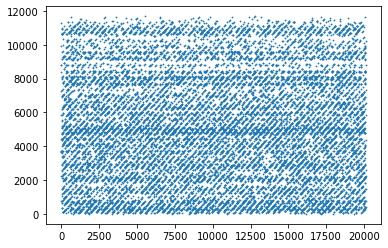

In [39]:
plt.scatter(range(0,20100), ss[0:20100,0,1], s=.6)


In [30]:
# example mpi day
ii = 0


In [46]:
# matching era days
jjs = ss[ii,:,1]
jjs = [int(jj) for jj in jjs]  # convert to ints (can't index w/ floats)
print(ss[ii])
print(jjs)

[[8.59062433e-01 3.69700000e+03]
 [8.57870221e-01 8.41700000e+03]
 [8.57110143e-01 1.42200000e+03]
 [8.55661511e-01 9.13400000e+03]
 [8.55525732e-01 9.54300000e+03]]
[3697, 8417, 1422, 9134, 9543]


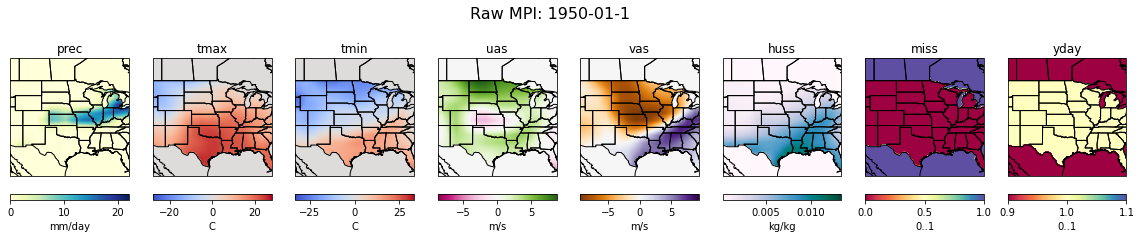

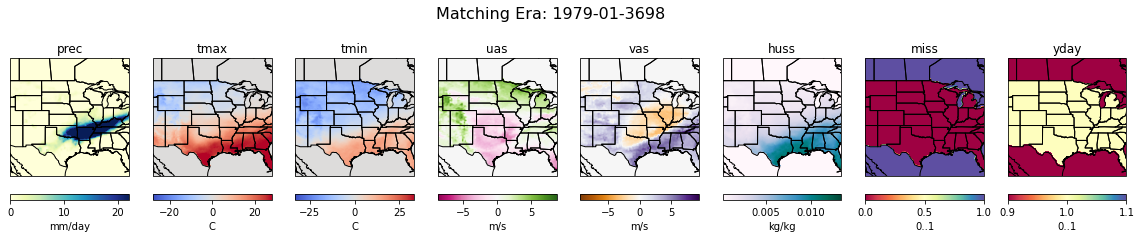

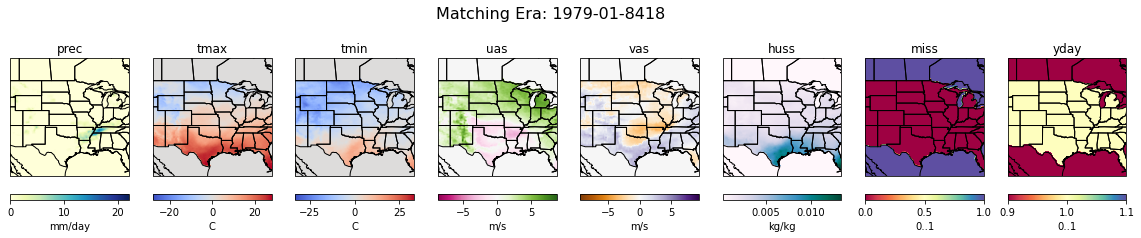

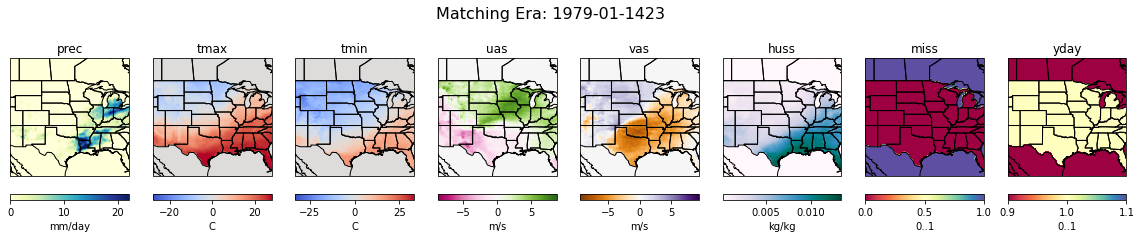

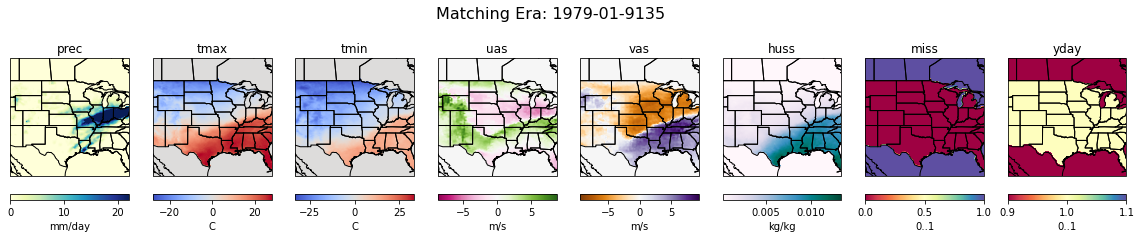

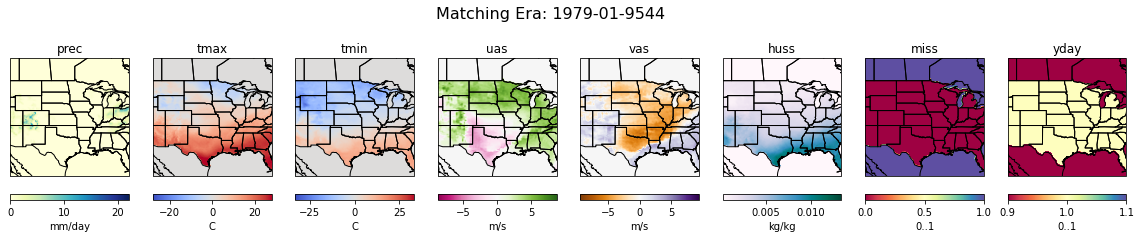

In [53]:
# Surface
# show matching days
input_mpi = load_mpi_hist(ii,ii+1)[0]
vmin = [input_mpi[ii].min() for ii in range(16)]
vmax = [input_mpi[ii].max() for ii in range(16)]
#vmin = [min(input_mpi[ii].min(),input_era[ii].min()) for ii in range(16)]
#vmax = [max(input_mpi[ii].max(),input_era[ii].max()) for ii in range(16)]
plot_8v_abs_surf(np.array(input_mpi), 'Raw MPI: 1950-01-{}'.format(ii+1), vmin, vmax, cc=False)

# top-5 era matches
for jj in jjs:
    input_era = load_era(jj,jj+1)[0]
    plot_8v_abs_surf(np.array(input_era), 'Matching Era: 1979-01-{}'.format(jj+1), vmin, vmax, cc=False)


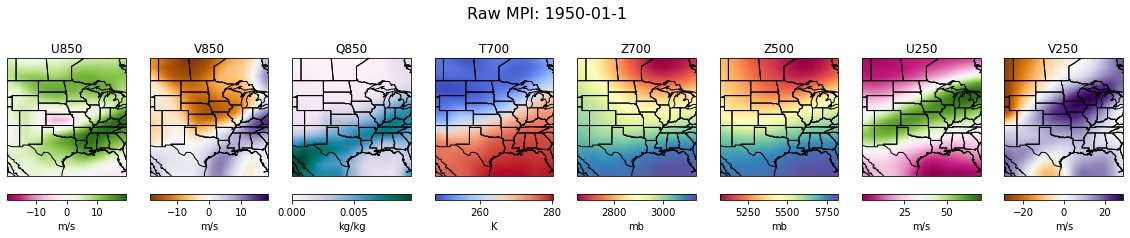

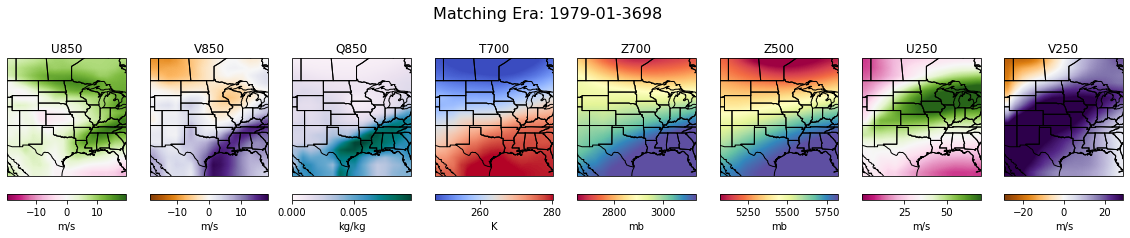

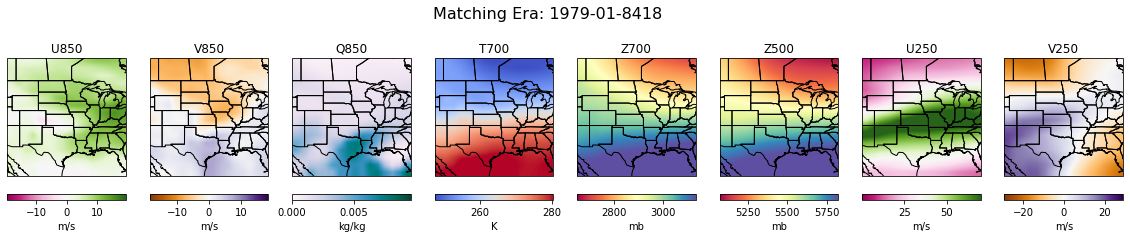

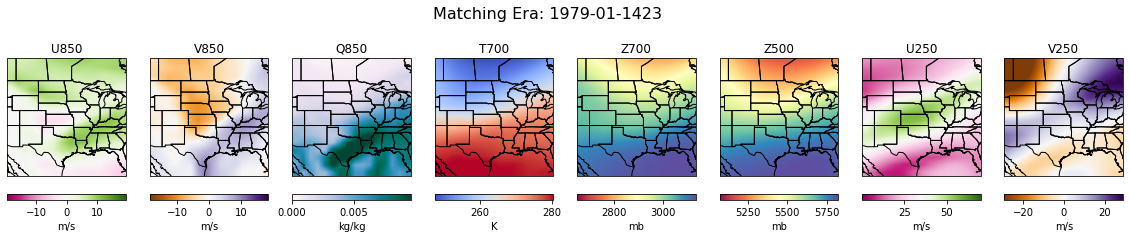

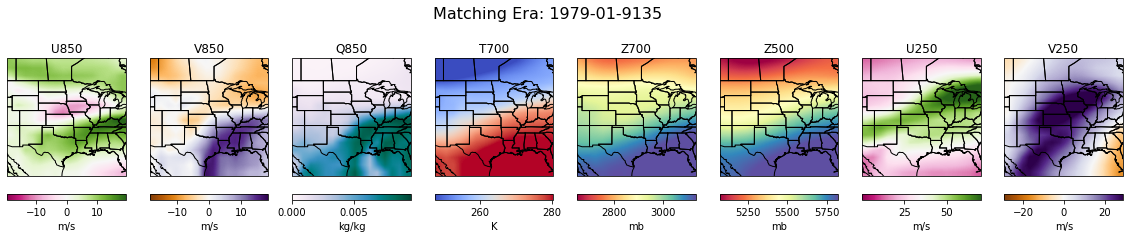

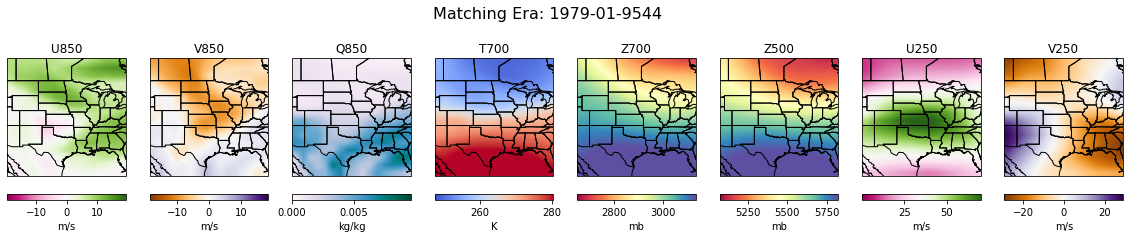

In [54]:
# Atm
# show matching days
input_mpi = load_mpi_hist(ii,ii+1)[0]
vmin = [input_mpi[ii].min() for ii in range(16)]
vmax = [input_mpi[ii].max() for ii in range(16)]
#vmin = [min(input_mpi[ii].min(),input_era[ii].min()) for ii in range(16)]
#vmax = [max(input_mpi[ii].max(),input_era[ii].max()) for ii in range(16)]
plot_8v_abs(np.array(input_mpi), 'Raw MPI: 1950-01-{}'.format(ii+1), vmin, vmax, cc=False)

# top-5 era matches
for jj in jjs:
    input_era = load_era(jj,jj+1)[0]
    plot_8v_abs(np.array(input_era), 'Matching Era: 1979-01-{}'.format(jj+1), vmin, vmax, cc=False)
